# Importing dataset from Kaggle

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shaileshkumar591","key":"0f38cd680a5366c16dc283b1b55e050d"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [02:12<00:00, 78.8MB/s]
100% 9.51G/9.51G [02:12<00:00, 77.2MB/s]


In [6]:
!unzip -q /content/aptos2019-blindness-detection.zip

# Installing required libraries

In [7]:
!pip install modin[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [9]:
! pip install albumentations

# Importing Libraries

In [17]:
import numpy as np
import modin.pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from random import randrange
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import os

In [10]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, PadIfNeeded
)

# Load Data

In [11]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

2024-03-21 20:04:39,800	INFO worker.py:1752 -- Started a local Ray instance.


In [12]:
# find out the number of images in test ans train sets
print('Number of images in training set is {}'.format(len(train)))
print('Number of images in test set is {}'.format(len(test)))

Number of images in training set is 3662
Number of images in test set is 1928


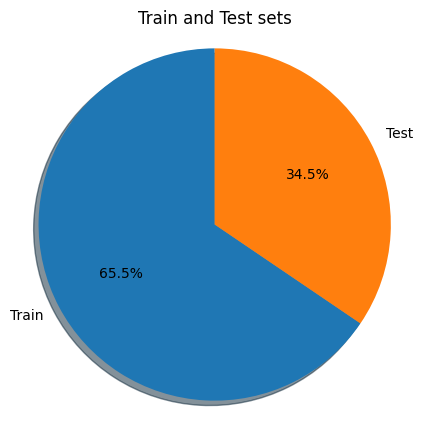

In [13]:
labels = 'Train', 'Test'
sizes = len(train), len(test)

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.title('Train and Test sets')
plt.show()

Both training and testing datasets are not too large.

Training dataset is about 3 times greater than the testing dataset.

#Analyze Train Set Labels
Plot pie chart with percentage of images of each diabetic retinopathy severity condition:

the groupby keys will be sorted anyway, although the 'sort=False' was passed. See the following issue for more details: https://github.com/modin-project/modin/issues/3571.


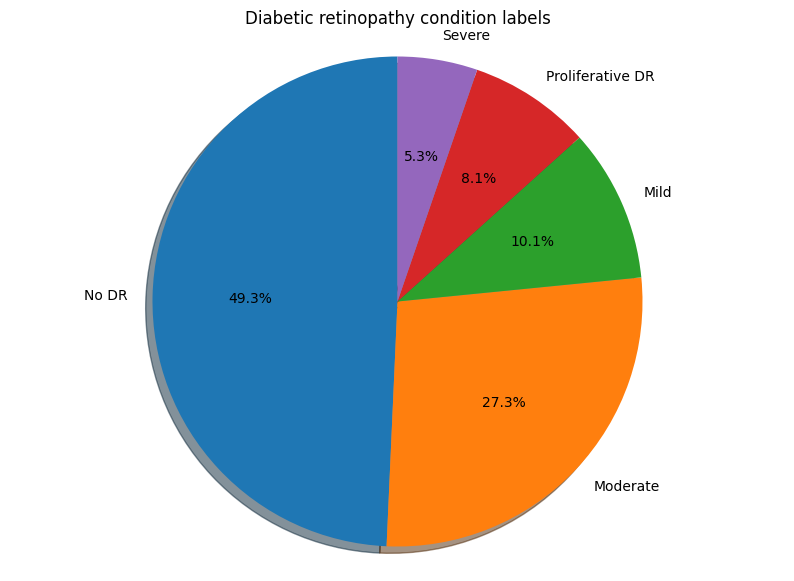

In [14]:
labels = 'No DR', 'Moderate', 'Mild', 'Proliferative DR', 'Severe'
sizes = train.diagnosis.value_counts()

fig1, ax1 = plt.subplots(figsize=(10,7))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.title('Diabetic retinopathy condition labels')
plt.show()

We can see that the training dataset is very imbalanced. There are ten times more images with no DR than images with the severe DR condition.

Data augmentation is required to perform the classification

# Visualize Sample Images

In [15]:
TRAIN_IMG_PATH = "/content/train_images"
TEST_IMG_PATH = "/content/test_images/"

# function to plot a grid of images
def view_fundus_images(images, title = ''):
    """
    Function to plot grid with several examples of fundus images.
    INPUT:
        train - array with filenames for images and condition labels

    OUTPUT: None
    """
    width = 5
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,5))

    for im in range(0, height * width):
        # open image
        image = Image.open(os.path.join(TRAIN_IMG_PATH,images[im] + '.png'))
        i = im // width
        j = im % width
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')

    # set suptitle
    plt.suptitle(title)
    plt.show()

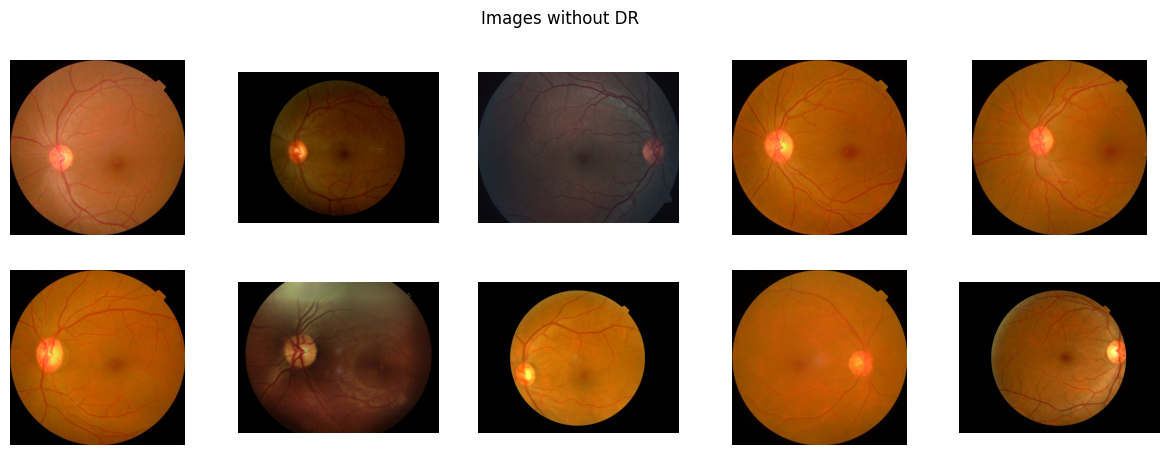

In [18]:
view_fundus_images(train[train['diagnosis'] == 0][:10].id_code.values, title = 'Images without DR')

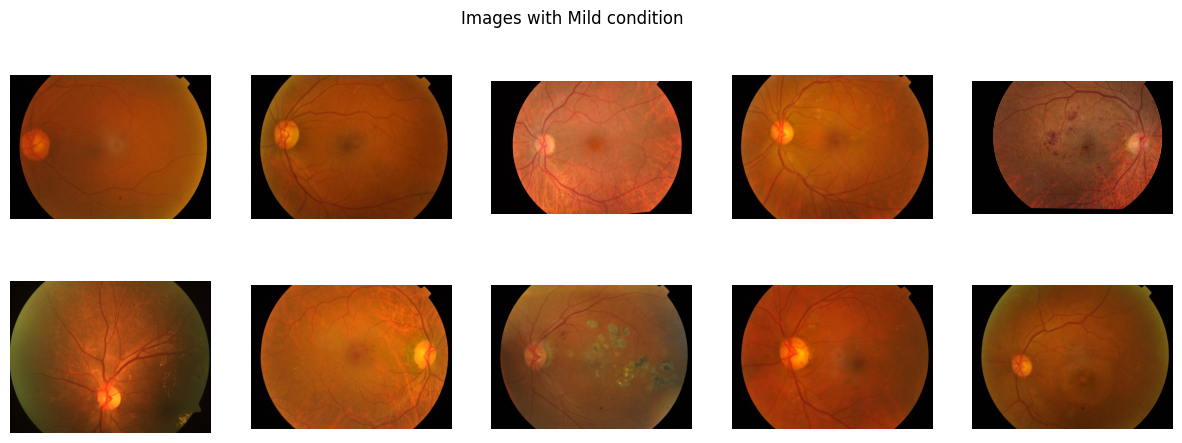

In [19]:
view_fundus_images(train[train['diagnosis'] == 1][:10].id_code.values, title = 'Images with Mild condition')

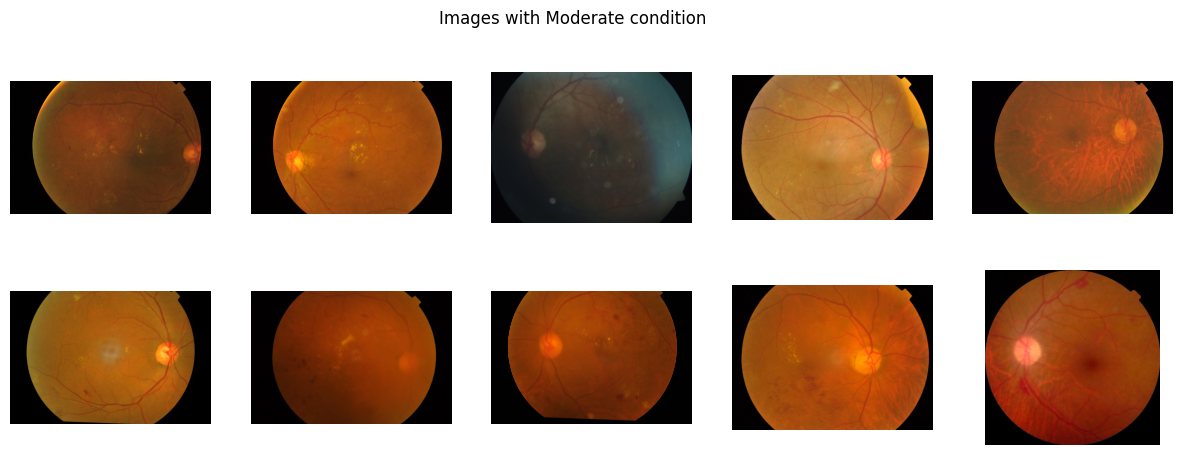

In [20]:
view_fundus_images(train[train['diagnosis'] == 2][:10].id_code.values, title = 'Images with Moderate condition')

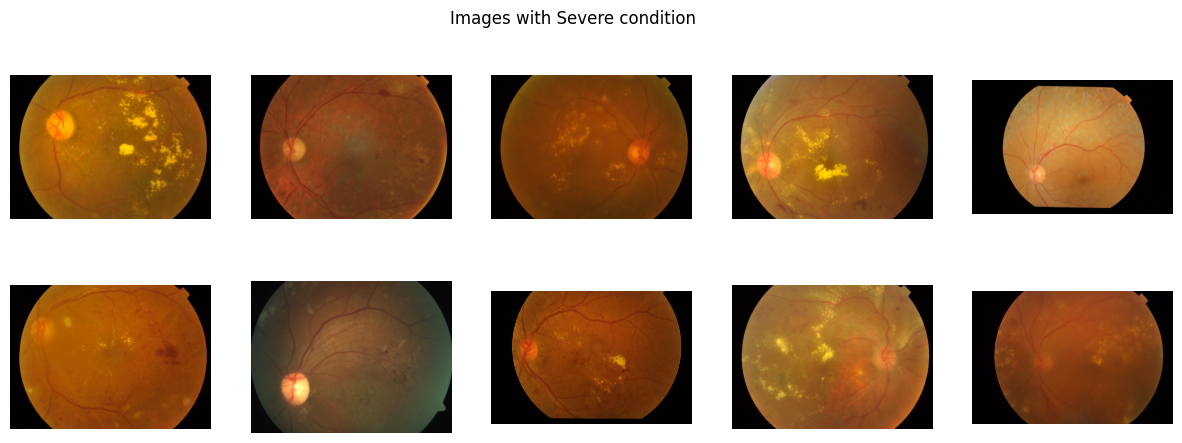

In [21]:
view_fundus_images(train[train['diagnosis'] == 3][:10].id_code.values, title = 'Images with Severe condition')

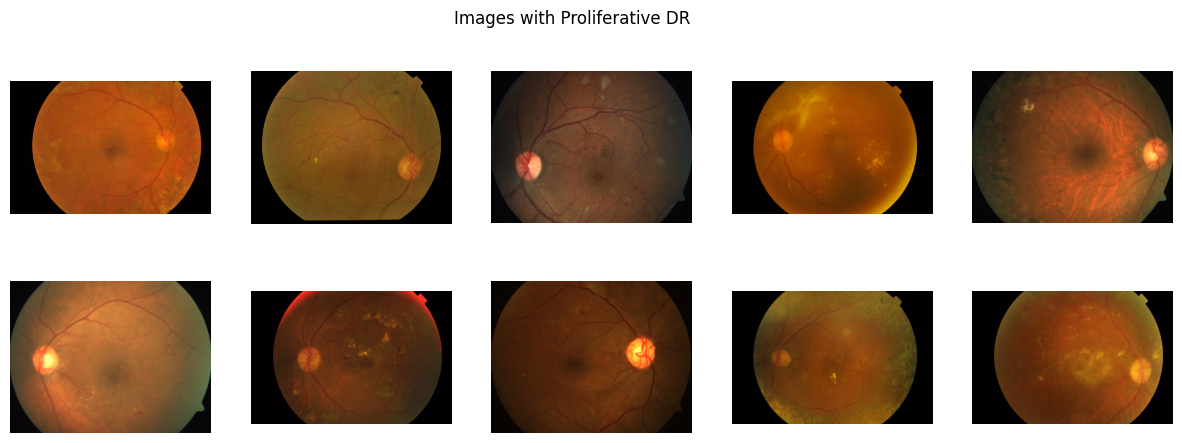

In [22]:
view_fundus_images(train[train['diagnosis'] == 4][:10].id_code.values, title = 'Images with Proliferative DR')

# Analyze Image Sizes

In [23]:
def get_image_sizes(df, train = True):
    '''
    Function to get sizes of images from test and train sets.
    INPUT:
        df - dataframe containing image filenames
        train - indicates whether we are getting sizes of images from train or test set
    '''
    if train:
        path = TRAIN_IMG_PATH
    else:
        path = TEST_IMG_PATH

    widths = []
    heights = []

    images = df.id_code

    max_im = Image.open(os.path.join(path, images[0] + '.png'))
    min_im = Image.open(os.path.join(path, images[0] + '.png'))

    for im in range(0, len(images)):
        image = Image.open(os.path.join(path, images[im] + '.png'))
        width, height = image.size

        if len(widths) > 0:
            if width > max(widths):
                max_im = image

            if width < min(widths):
                min_im = image

        widths.append(width)
        heights.append(height)

    return widths, heights, max_im, min_im

In [24]:
# get sizes of images from test and train sets
train_widths, train_heights, max_train, min_train = get_image_sizes(train, train = True)
test_widths, test_heights, max_test, min_test = get_image_sizes(test, train = False)

In [25]:
print('Maximum width for training set is {}'.format(max(train_widths)))
print('Minimum width for training set is {}'.format(min(train_widths)))
print('Maximum height for training set is {}'.format(max(train_heights)))
print('Minimum height for training set is {}'.format(min(train_heights)))

Maximum width for training set is 4288
Minimum width for training set is 474
Maximum height for training set is 2848
Minimum height for training set is 358


In [26]:
print('Maximum width for test set is {}'.format(max(test_widths)))
print('Minimum width for test set is {}'.format(min(test_widths)))
print('Maximum height for test set is {}'.format(max(test_heights)))
print('Minimum height for test set is {}'.format(min(test_heights)))

Maximum width for test set is 2896
Minimum width for test set is 640
Maximum height for test set is 1958
Minimum height for test set is 480



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



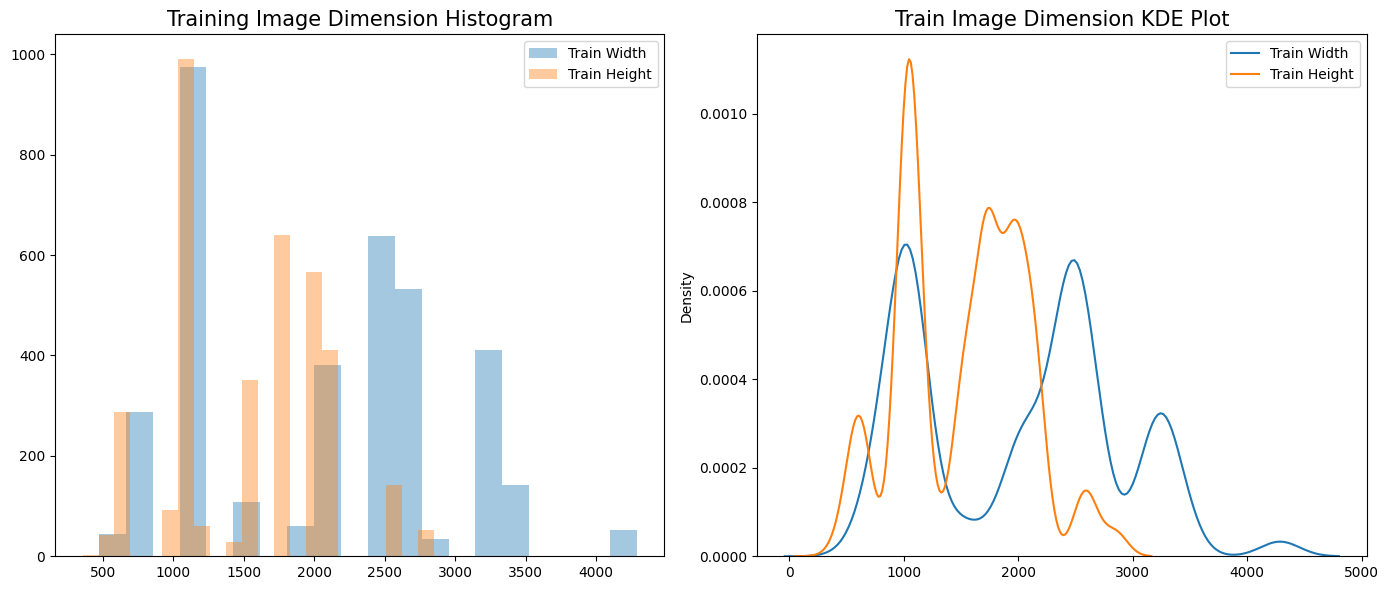

In [27]:
plt.figure(figsize=(14,6))
plt.subplot(121)
sns.distplot(train_widths, kde=False, label='Train Width')
sns.distplot(train_heights, kde=False, label='Train Height')
plt.legend()
plt.title('Training Image Dimension Histogram', fontsize=15)

plt.subplot(122)
sns.kdeplot(train_widths, label='Train Width')
sns.kdeplot(train_heights, label='Train Height')
plt.legend()
plt.title('Train Image Dimension KDE Plot', fontsize=15)

plt.tight_layout()
plt.show()

# Playing with Augmentations

In [28]:
diagnosis_dict = {
    0:'No DR',
    1:'Mild',
    2:'Moderate',
    3: 'Severe',
    4: 'Proliferative DR'
}

In [31]:
def view_fundus_images_labels(train, rand_indices, aug = None, title = ''):
    """
    Function to plot grid with several examples of fundus images.
    INPUT:
        train - array with filenames for images and condition labels
        rand_indices - indices of images to plot
        title - plot title

    OUTPUT: None
    """
    width = 5
    height = 2
    counter = 0
    fig, axs = plt.subplots(height, width, figsize=(15,5))

    for im in rand_indices:
        # open image
        image = Image.open(os.path.join(TRAIN_IMG_PATH, train.iloc[im].id_code + '.png'))

        if aug is not None:
            image = aug(image=np.array(image))['image']

        i = counter // width
        j = counter % width
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')

        diagnosis = train[train['id_code'] == train.iloc[im].id_code].diagnosis.values[0]

        axs[i,j].set_title(diagnosis_dict[diagnosis])
        counter += 1

    # set suptitle
    plt.suptitle(title)
    plt.show()

In [32]:
# get some random image indices from the training set
rand_indices = [randrange(len(train)) for x in range(0,10)]
rand_indices

[3285, 2064, 2421, 989, 288, 1662, 530, 2866, 3261, 1629]

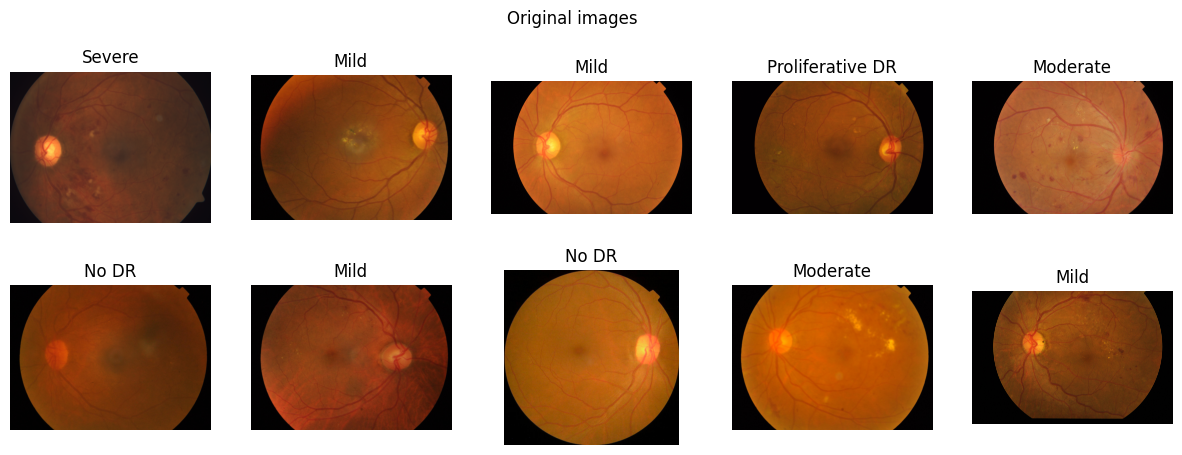

In [33]:
view_fundus_images_labels(train, rand_indices, title = 'Original images')

Applying CLAHE:

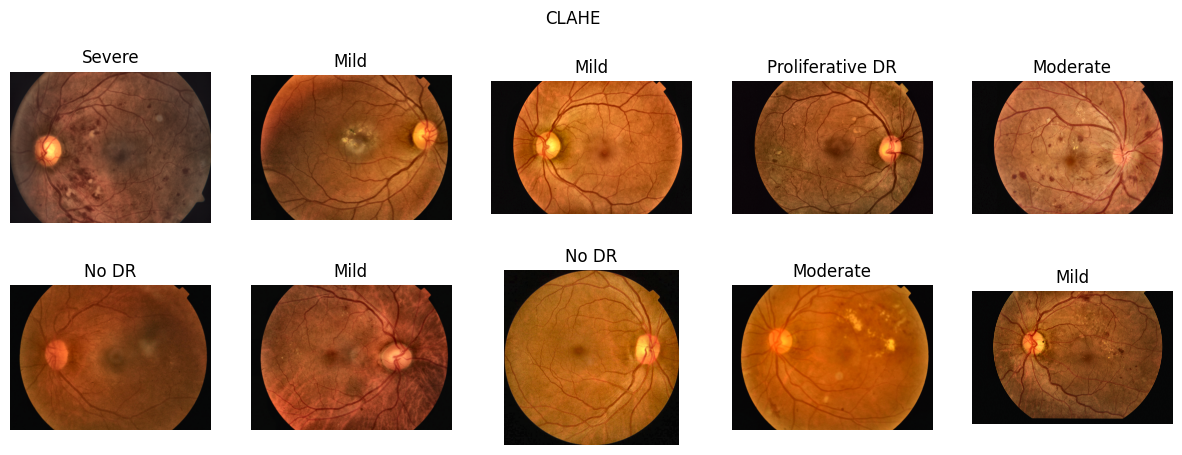

In [34]:
aug = CLAHE(p=1)
view_fundus_images_labels(train, rand_indices, aug, title = 'CLAHE')

Applying some random Gaussian Noise

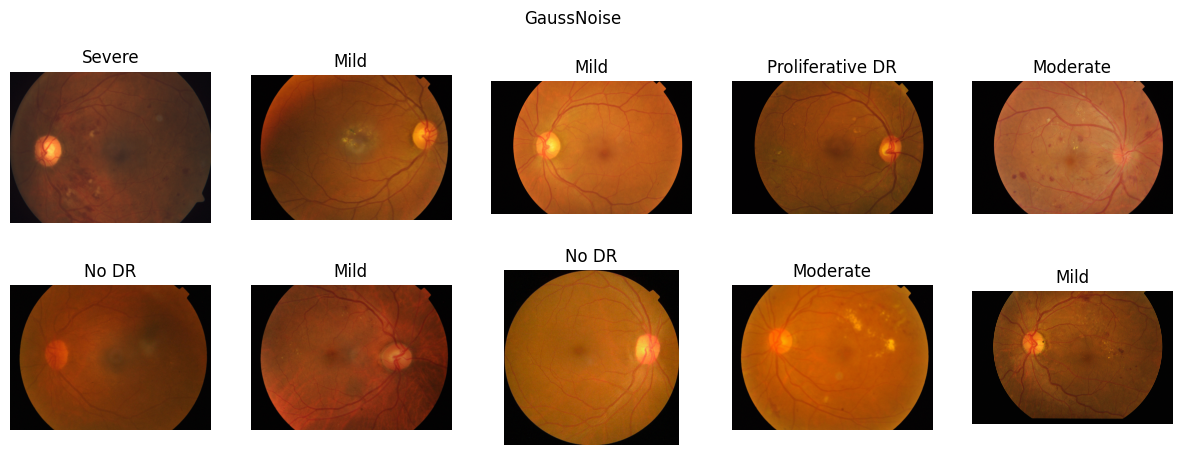

In [36]:
aug = GaussNoise(p=1)
view_fundus_images_labels(train, rand_indices, aug, title = 'GaussNoise')

Applying Brightness and Contrast

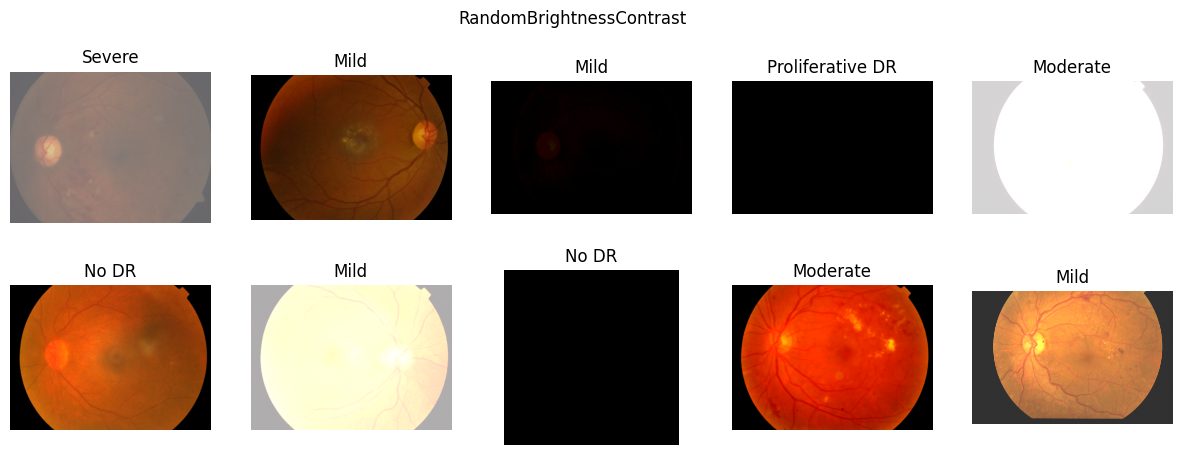

In [37]:
aug = RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p = 1)
view_fundus_images_labels(train, rand_indices, aug, title = 'RandomBrightnessContrast')

Applying Padding:

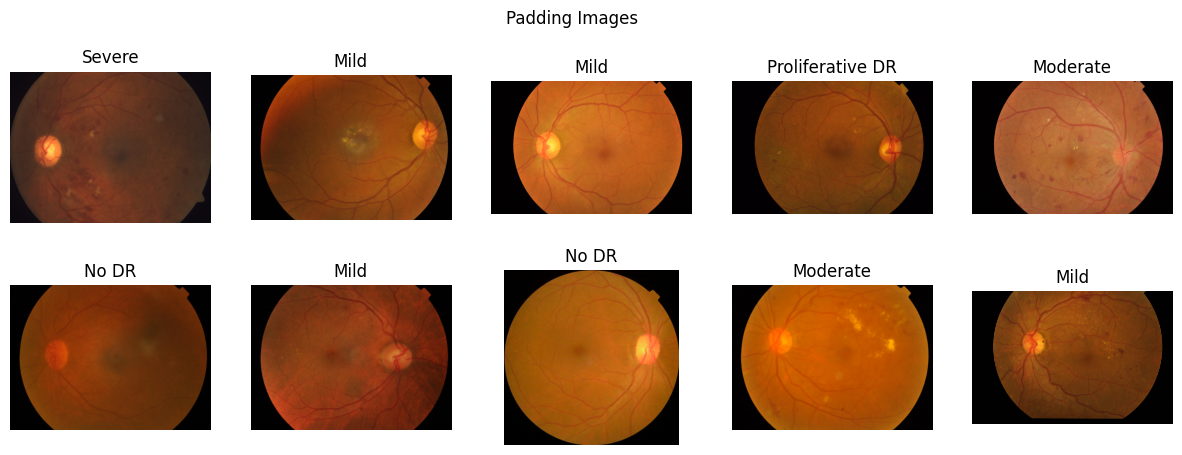

In [38]:
aug = PadIfNeeded(min_height=1024, min_width=1024, p = 1)
view_fundus_images_labels(train, rand_indices, aug, title = 'Padding Images')

#Conclusion
After the EDA we can say the following:

The dataset is heavily imbalanced. Data augmentation is required.
The distribution of sizes of images from train and test sets is different. This will probably have an impact on classification results.
In this EDA we also explored augmented images to have an impression what augmented dataset will look like.